# `StableSpectralElements.jl` - 3D linear advection example

First, let's load the required packages.

In [48]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, Printf, TimerOutputs, BenchmarkTools

We will solve the three-dimensional linear advection equation
$$
\partial_t U(\boldsymbol{x},t) + \nabla_{\boldsymbol{x}} \cdot (\boldsymbol{a} U(\boldsymbol{x},t)) = 0,  \quad \forall\, (\boldsymbol{x}, t) \in \Omega \times (0,T),
$$
with $a = [1,1,1]^{\mathrm{T}}$ and $\Omega = (0,L)^3$, where we take $L = 1$, and $T = 1$, and impose periodic boundary conditions as well as the initial condition
$$
U(\boldsymbol{x},0) = \cos(2\pi x_1 / L)\cos(2\pi x_2 / L)\cos(2\pi x_3 / L), \quad \forall \, \boldsymbol{x} \in \Omega.
$$

In [49]:
a = (3/2,1/2,1/sqrt(2))  # advection velocity
L = 1.0  # domain length
T = 0.001  # end time

conservation_law = LinearAdvectionEquation(a)
#exact_solution = InitialDataCosine(1.0,(2π/L, 2π/L, 2π/L));
exact_solution= DataSine(1.0, 2.0*π, a);

We'll discretize the above problem using a `ModalTensor` discretization of degree $p = 7$, on a curved (i.e. using a mapping of degree $p_{\mathrm{map}} = 3$) tetrahedral mesh with $M = 2$ edges in each direction. A skew-symmetric split form will be used to treat the curvilinear coordinate transformation in a provably stable manner, and we will use an upwind (i.e. Lax-Friedrichs) numerical flux.

In [50]:
M = 4
p = 1

reference_approximation = ReferenceApproximation(
    NodalMultiDiagE(p), Tet(), mapping_degree=p)

#println((reference_approximation.D[1]))

form = StandardForm(mapping_form=SkewSymmetricMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(1.0))

uniform_mesh = uniform_periodic_mesh(reference_approximation,
    ((0.0,L),(0.0,L),(0.0,L)), (M,M,M))

mesh = warp_mesh(uniform_mesh, reference_approximation, 0.0, L) 

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation, ExactMetrics())

results_path = save_project(conservation_law,
     spatial_discretization, exact_solution, form, (0.0, T),
     "results/advection_3d/", overwrite=true, clear=true);

We will now plot the reference element, with the volume quadrature nodes shown on the left and the facet quadrature nodes shown on the right.

In [51]:
vol_quad_plot = plot(reference_approximation, volume_connect=true, 
    facet_quadrature=false, fmt=:png, size=(300,300))
fac_quad_plot = plot(reference_approximation, facet_connect=true, 
    volume_quadrature=false, fmt=:png, size=(300,300), facet_inds=[3,4,1,2])
plot(vol_quad_plot,fac_quad_plot,size=(600,300),margin=5mm, fmt=:png)

BoundsError: BoundsError: attempt to access 7-element Vector{Float64} at index [[4, 8]]

The mesh is shown below.

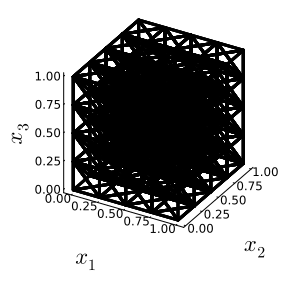

In [52]:
plot(spatial_discretization, volume_quadrature=false, facet_quadrature=false, fmt=:png, size=(300,300))

Using the `semidiscretize` function, we can create an `ODEProblem` object for use with OrdinaryDiffEq.jl's `solve` function. Here we've chosen the option for a weight-adjusted approximation of the mass matrix inverse from [Chan et al. (SISC 2017)](https://arxiv.org/abs/1608.03836), which allows for modal schemes to be applied efficiently at high order with explicit time-marching methods.

In [53]:
CFL = 0.1
h = L/(reference_approximation.N_p * spatial_discretization.N_e)^(1/3)
dt = CFL * h / sqrt(a[1]^2 + a[2]^2 + a[3]^2)
dt = 0.0001
ode_problem = semidiscretize(conservation_law, spatial_discretization,
    exact_solution, form, (0.0, T), ReferenceOperator());
display(ode_problem)
display(size(ode_problem.u0)[1]*size(ode_problem.u0)[3])

ODEProblem with uType Array{Float64, 3} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 0.001)
u0: 7×1×384 Array{Float64, 3}:
[:, :, 1] =
  4.597539363207435e-33
 -8.724359200318984e-17
 -5.03430454055825e-17
 -6.690533317637419e-33
 -1.6732971127749326e-16
  0.3535533905932736
  0.10355339059327373

[:, :, 2] =
 -2.591346239840616e-16
  0.4999999999999998
  9.778492200902093e-17
 -1.8382681054762932e-17
 -2.3663994707660523e-16
  0.3535533905932736
  0.25000000000000006

[:, :, 3] =
 0.5
 0.7071067811865474
 9.778492200902093e-17
 0.353553390593274
 0.7071067811865472
 0.49999999999999983
 0.603553390593274

;;; … 

[:, :, 382] =
 -2.8889539797233863e-30
 -1.0106430996148645e-15
 -1.731912112470987e-16
  7.657137397853875e-16
 -2.888953979723386e-30
 -0.35355339059327506
 -0.10355339059327366

[:, :, 383] =
 -1.4292651781941216e-15
 -1.4292651781941216e-15
 -0.4999999999999994
  1.0828827556999206e-15
 -1.0106430996148645e-15
 -0.35355339059327506
 -0.

2688

In [54]:
reset_timer!()
sol = solve(ode_problem, CarpenterKennedy2N54(), adaptive=false, dt=dt,
    save_everystep=false, 
    callback=save_callback(results_path, (0.0,T)))
print_timer()

────────────────────────────────────────────────────────────────────────────────
                                       Time                    Allocations      
                              ───────────────────────   ────────────────────────
      Tot / % measured:           24.5ms /  80.5%           12.6MiB /  92.9%    

Section               ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────────
semi-disc. residual       62   19.7ms  100.0%   318μs   11.7MiB  100.0%   194KiB
────────────────────────────────────────────────────────────────────────────────


We can then compute the $L^2$ norm of the solution error using the scheme's volume quadrature rule.

In [55]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)

L2 error:
0.0030747849379551876


The conservation and energy dissipation properties of the scheme are verified as follows.

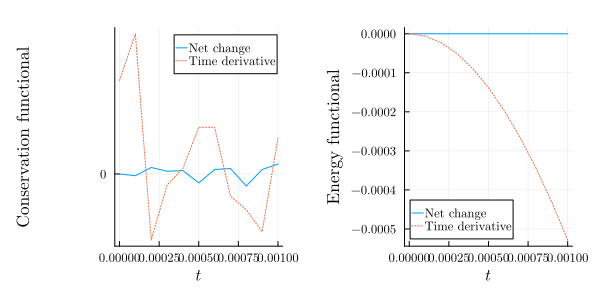

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jerrybai/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jerrybai/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jerrybai/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jerrybai/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jerrybai/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jerrybai/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/jerrybai/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [56]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Conservation functional",)
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), 
    ylabel="Energy functional")
plot(p1,p2, size=(600,300),margin=5mm, fmt=:png)

We can now postprocess the solution for visualization, producing a `.vtu` file.

In [57]:
postprocess_vtk(spatial_discretization,
    string(results_path,"solution.vtu"), last(sol.u));